# Voltage Plots

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate, integrate
from scipy.optimize import curve_fit
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
import winsound

eSOH_DIR = "../data/esoh_R/"
oCV_DIR = "../data/ocv/"
hppc_DIR = "../data/hppc/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
resistance_DIR = "../data/resistance/"
%matplotlib widget

In [2]:
parameter_values = get_parameter_values()

In [3]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        # "stress-induced diffusion": "false",
        # "calculate discharge energy": "true"
    }
)
# spm.print_parameter_info()
param=spm.param

In [4]:
spm1 = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        "stress-induced diffusion": "false",
        # "calculate discharge energy": "true"
    }
)

In [5]:
spme = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
    }
)


In [6]:
cell = 10
sno = 1
sim_des = f'cond{sno}'

In [7]:
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(Temp)

25


In [8]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    # ] *1,
    termination="50% capacity",
#     cccv_handling="ode",
)

In [9]:
par_val = {}
# Previous i.e. tuning mech sim sep and then Li plating
par_val[0]=[1.2715e-07,1.2727e-06,1.1992,1.353e-9]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,x100,y0
par_val[1]=[1.4819e-07,1.5114e-06,1.2484,1.4732e-09]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[2]=[1.4493e-07,1.3608e-06,1.199,1.2138e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,x100,y0
par_val[3]=[1.043e-07,1.036e-06,1.208,1.6045e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[4]=[8.755e-08,8.572e-07,1.135,1.5788e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%) another initial condition
par_val[5]=[8.7698e-08,8.5848e-07,1.1354,1.5778e-09]
# Using C/5, 2C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[6]=[2.9056e-07,2.6764e-06,1.3792,1.2686e-09]

In [10]:
parameter_values.search("diffusion")

Negative electrode diffusion coefficient [m2.s-1]	8e-14
Positive electrode diffusion coefficient [m2.s-1]	8e-15


In [11]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        # "Negative electrode diffusion coefficient [m2.s-1]":8.0E-15,
        # "Positive electrode diffusion coefficient [m2.s-1]":8.0E-16,
    },
    check_already_exists=False,
)


In [12]:
# dfgf

# Aging Sim

In [13]:
# all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)


In [14]:
# sdfsd

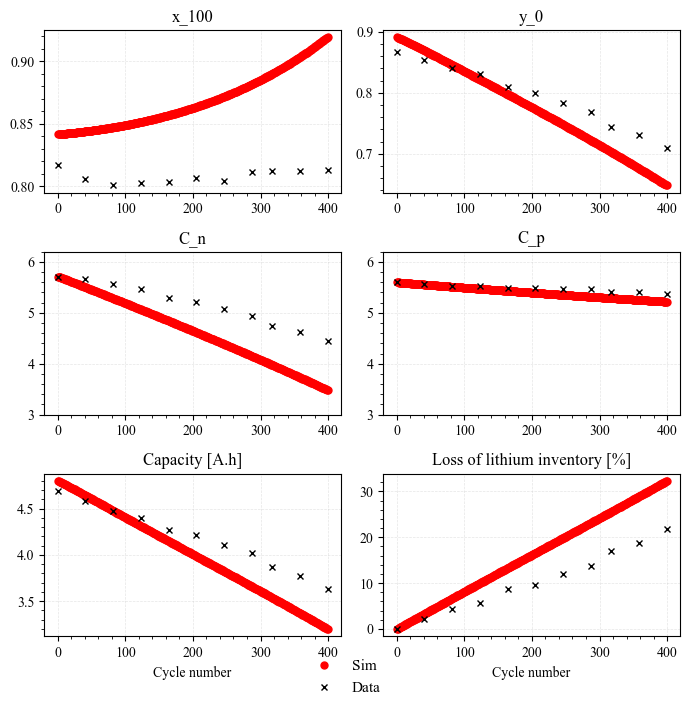

In [15]:
fig = plotc(all_sumvars_dict,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_'+sim_des + '.png')

In [16]:
# asdas

## Aging Sim 2

In [17]:
# fig = plotc(all_sumvars_dict,dfe);
# plt.savefig(fig_DIR +'plating_tuning_'+sim_des+'_'+cell_no+'_eSOH.png')

In [18]:
# sno = 2
# parameter_values.update(
#     {
#         "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
#         "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
#         "Positive electrode LAM constant exponential term": par_val[sno][2],
#         "Negative electrode LAM constant exponential term": par_val[sno][2],
#         "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
#         # "Negative electrode diffusion coefficient [m2.s-1]":8.0E-15,
#         # "Positive electrode diffusion coefficient [m2.s-1]":8.0E-16,
#         # "SEI resistivity [Ohm.m]": 30000.0,
#     },
#     check_already_exists=False,
# )


In [19]:
# experiment = pybamm.Experiment(
#     [
#         ("Discharge at "+c_rate_d+dis_set,
#          "Rest for 5 min",
#          "Charge at "+c_rate_c+" until 4.2V", 
#          "Hold at 4.2V until C/50")
#     ] *dfe.N.iloc[-1],
#     # ] *40,
#     termination="50% capacity",
# #     cccv_handling="ode",
# )

In [20]:
all_sumvars_dict1 = cycle_adaptive_simulation(spm1, parameter_values, experiment,SOC_0, save_at_cycles=1)

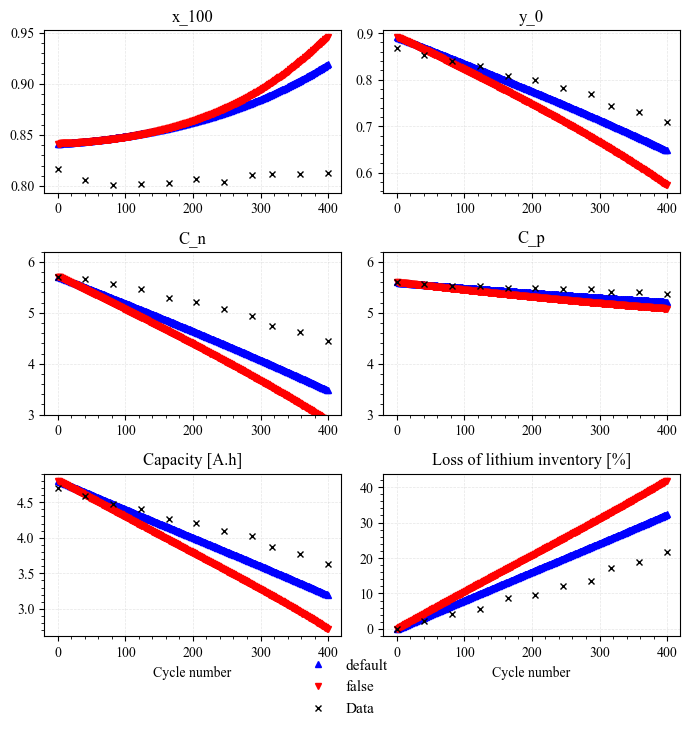

In [21]:
fig = plotc2(all_sumvars_dict,all_sumvars_dict1,dfe,leg1="default",leg2="false");
# plt.savefig(fig_DIR +'plating_tuning_'+sim_des+'_'+cell_no+'_eSOH_comp.png')

In [22]:
dfdsf

NameError: name 'dfdsf' is not defined

In [ ]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=1)
long_sol_output =sol_long.summary_variables

In [ ]:
sol1 = sol_long.cycles[0]
sol2 = sol_long.cycles[-1]

In [ ]:
(min(I_Li)+min(I_sei))/min(I_de)

In [ ]:
t1 = sol1["Time [s]"].entries
t1 = t1 - t1[0]
I1 = sol1["Current [A]"].entries
Q1 = -sol1['Discharge capacity [A.h]'].entries
Vt1 = sol1["Terminal voltage [V]"].entries
I_Li1 = sol1["X-averaged lithium plating interfacial current density [A.m-2]"].entries
Q_Li1 = sol1["Loss of capacity to lithium plating [A.h]"].entries
i0_int1 = sol1["X-averaged negative electrode exchange current density [A.m-2]"].entries
I_de1 = sol1["X-averaged negative electrode interfacial current density [A.m-2]"].entries
I_to1 = sol1["X-averaged negative electrode total interfacial current density [A.m-2]"].entries
I_sei1 = sol1["X-averaged SEI interfacial current density [A.m-2]"].entries

t2 = sol2["Time [s]"].entries
t2 = t2 - t2[0]
I2 = sol2["Current [A]"].entries
Q2 = -sol2['Discharge capacity [A.h]'].entries
Vt2 = sol2["Terminal voltage [V]"].entries
I_Li2 = sol2["X-averaged lithium plating interfacial current density [A.m-2]"].entries
Q_Li2 = sol2["Loss of capacity to lithium plating [A.h]"].entries
i0_int2 = sol2["X-averaged negative electrode exchange current density [A.m-2]"].entries
I_de2 = sol2["X-averaged negative electrode interfacial current density [A.m-2]"].entries
I_to2 = sol2["X-averaged negative electrode total interfacial current density [A.m-2]"].entries
I_sei2 = sol2["X-averaged SEI interfacial current density [A.m-2]"].entries



fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax1 = axes.flat[0]
ax1.plot(t1,I_de1,'b')
ax1.plot(t2,I_de2,'r')
ax1.set_title(r'$j_{int}$ [A.$m^{-2}$]')
ax2=axes.flat[1]
ax2.plot(t1,I_sei1,'b')
ax2.plot(t2,I_sei2,'r')
ax2.set_title(r'$j_{sei}$ [A.$m^{-2}$]')
ax2.axhline(y = 0.0, color = 'k', linestyle = '--')
ax3 = axes.flat[2]
ax3.plot(t1,I_Li1,'b')
ax3.plot(t2,I_Li2,'r')
ax3.axhline(y = 0.0, color = 'k', linestyle = '--')
ax3.set_title(r'$j_{pl}$ [A.$m^{-2}$]')


ax1.set_xlabel("Time [hr]")
ax2.set_xlabel("Time [hr]")
ax3.set_xlabel("Time [hr]")
fig.suptitle("1.5C Fresh Cell")
fig.tight_layout()
plt.savefig(fig_DIR+'compare_currents_fresh'+'.png')

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5))
ax1 = axes
ax1.plot(t1/3600,I_de1,'k')
ax1.plot(t2/3600,I_de2,'k--')
ax1.plot(t1/3600,I_sei1*1e4,'r')
ax1.plot(t2/3600,I_sei2*1e4,'r--')
ax1.plot(t1/3600,I_Li1*1e3,'b')
ax1.plot(t2/3600,I_Li2*1e3,'b--')
ax1.set_xlabel("Time [hr]",fontsize=14)
ax1.set_ylabel(r"Current Density [A.$m^{-2}$]",fontsize=14)
ax1.legend([r"$j_{int}$ fresh",r"$j_{int}$ aged",r"$j_{sei}\times10^4$ fresh",r"$j_{sei}\times10^4$ aged", r"$j_{pl}\times10^3$ fresh",r"$j_{pl}\times10^3$ aged"])
fig.suptitle("Current Densities for Fresh and Aged Cell",fontsize=16)
fig.tight_layout()
plt.savefig(fig_DIR+'compare_currents_fresh_aged'+'.png')

In [ ]:
dfgd

In [ ]:
def plotc2(all_sumvars_dict1,all_sumvars_dict2,esoh_data,leg1="sim1",leg2="sim2"):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"b^")
        ax.plot(all_sumvars_dict2["Cycle number"],all_sumvars_dict2[name],"rv")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        if k ==2 or k==3:
            ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend([leg1, leg2 , "Data"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.05], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [ ]:
fig = plotc2(all_sumvars_dict,long_sol_output,dfe,leg1="Accelerated",leg2="Normal");
fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_normal.png')

In [ ]:
# sdfsdfs

In [ ]:
# sim_des = "Dsp"
# fig = plotc2(all_sumvars_dict,all_sumvars_dict1,dfe,leg1="Ds,p",leg2="Ds,p/10");
# plt.savefig(fig_DIR +'plating_tuning_'+sim_des+'_'+cell_no+'_eSOH_comp.png')

In [ ]:
fgfgfgfg

# Cycling Voltage Plots 

## Voltage Components

In [ ]:
dis_set = " until 3V"

experiment_cyc_comp = pybamm.Experiment(
    [
        "Discharge at "+c_rate_d+dis_set,
        # "Rest for 10 sec",
        "Charge at "+c_rate_c+" until 4.2V", 
        "Hold at 4.2V until C/50",
        # "Rest for 10 sec",
        "Discharge at "+c_rate_d+dis_set,
    ],
)
Ns = np.insert(N[1:]-1,0,0)

In [ ]:
def load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:-1]
    print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    N1 = cycles[cyc_no]
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    idx_I = idx_I[idx_I>50]
    # t = t_c1[:idx_I[0]]
    # V = V_c1[:idx_I[0]]
    # I = I_c1[:idx_I[0]]
    t = t_c1
    V = V_c1
    I = I_c1
    Q = integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q


In [ ]:
def cyc_comp(cyc_no,eSOH,Q_d,V_d,parameter_values):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    print(Cn)
    Cp = eSOH["C_p"][Ns[cyc_no]]
    print(Cp)
    del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
    print(del_sei)
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            "Initial inner SEI thickness [m]": 0e-09,
            "Initial outer SEI thickness [m]": del_sei,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_cyc_comp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [s]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(-I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
    I = I_t[idx[0]:]
    t = t_t[idx[0]:]-t_t[idx[0]]
    Q = Q_t[idx[0]:]-Q_t[idx[0]]
    Vt = Vt_t[idx[0]:]
    exp = exp_t[idx[0]:]-exp_t[idx[0]]
    # I = I_t
    # t = t_t-t_t[0]
    # Q = Q_t-Q_t[0]
    # Vt = Vt_t
    # exp = exp_t-exp_t[0]
    # # Q_filt = ((Q/max(Q))>0.15)
    # int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
    # rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    # V_err = Vt*Q_filt-int_V(Q)*Q_filt
    # V_max_loc = np.argmax(abs(V_err))
    # V_err_Q = Q[V_max_loc]
    # V_err_max = V_err[V_max_loc]
    # if max(Q)<max(Q_d):
    #     int_V = interpolate.CubicSpline(Q_d,V_d,extrapolate=True)
    #     rmse_V = pybamm.rmse(Vt,int_V(Q))
    #     V_err = Vt-int_V(Q)
    #     max_V = abs(V_err[-2])
    #     V_max_loc = np.argmax(abs(V_err))
    #     V_err_Q = Q[V_max_loc]
    #     V_err_max = V_err[V_max_loc]
    #     Q_err = Q
    # else:
    #     int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
    #     rmse_V = pybamm.rmse(V_d,int_V(Q_d))
    #     V_err = int_V(Q_d)-V_d
    #     max_V = abs(V_err[-2])
    #     V_max_loc = np.argmax(abs(V_err))
    #     V_err_Q = Q_d[V_max_loc]
    #     V_err_max = V_err[V_max_loc]
    rmse_V =0
    max_V = 0
    return t,I,Q,Vt,exp,sol_exp,rmse_V,max_V

In [ ]:
i = 0
rmse_V_lc = []
titles = ["BOL","EOL"]
xlim=[0.621,0.428]
# for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
# for cyc_no in [0,len(N)-2]:
for cyc_no in [0]:
    print(cyc_no)
    t_d,V_d,I_d,Q_d = load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[2][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[2][1],
        "Positive electrode LAM constant exponential term": par_val[2][2],
        "Negative electrode LAM constant exponential term": par_val[2][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[2][3],
        "SEI resistivity [Ohm.m]": 30000.0,
    },
    check_already_exists=False,
    )
    t,I,Q,Vt,exp,sol,rmse_V,max_V = cyc_comp(cyc_no,all_sumvars_dict,Q_d,V_d,parameter_values)
    fig, axes = plt.subplots(1,1,figsize=(7,5))
    ax = axes
    pybamm.plot_voltage_components(sol,ax)
    ax.set_xlim(left=xlim[i])
    ax.set_ylabel("Voltage [V]")
    ax.set_title('{}'.format(titles[i]))
    plt.savefig(fig_DIR +'volt_components'+'_'+cell_no+'_'+titles[i]+'.png')
    i+=1

In [ ]:
i = 0
rmse_V_lc = []
titles = ["BOL","EOL"]
xlim=[0.621,0.428]
# for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
# for cyc_no in [0,len(N)-2]:
for cyc_no in [len(N)-2]:
    print(cyc_no)
    t_d,V_d,I_d,Q_d = load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[2][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[2][1],
        "Positive electrode LAM constant exponential term": par_val[2][2],
        "Negative electrode LAM constant exponential term": par_val[2][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[2][3],
        "SEI resistivity [Ohm.m]": 30000.0,
    },
    check_already_exists=False,
    )
    t1,I1,Q1,Vt1,exp1,sol1,rmse_V,max_V = cyc_comp(cyc_no,all_sumvars_dict,Q_d,V_d,parameter_values)
    fig, axes = plt.subplots(1,1,figsize=(7,5))
    ax = axes
    pybamm.plot_voltage_components(sol1,ax)
    ax.set_xlim(left=xlim[i])
    ax.set_ylabel("Voltage [V]")
    ax.set_title('{}'.format(titles[i]))
    plt.savefig(fig_DIR +'volt_components'+'_'+cell_no+'_'+titles[i]+'.png')
    i+=1

In [ ]:
t = sol['Time [s]'].entries
seif_pot = sol['X-averaged SEI film overpotential [V]'].entries
ocv_n = sol['X-averaged negative electrode open circuit potential [V]'].entries
eta_n = sol['X-averaged negative electrode reaction overpotential [V]'].entries
ocv_p = sol['X-averaged positive electrode open circuit potential [V]'].entries
eta_p = sol['X-averaged positive electrode reaction overpotential [V]'].entries
Vt = sol["Terminal voltage [V]"].entries

In [ ]:
t1 = sol1['Time [s]'].entries
seif_pot1 = sol1['X-averaged SEI film overpotential [V]'].entries
ocv_n1 = sol1['X-averaged negative electrode open circuit potential [V]'].entries
eta_n1 = sol1['X-averaged negative electrode reaction overpotential [V]'].entries
ocv_p1 = sol1['X-averaged positive electrode open circuit potential [V]'].entries
eta_p1 = sol1['X-averaged positive electrode reaction overpotential [V]'].entries
Vt1 = sol1["Terminal voltage [V]"].entries

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(7,5))
ax = axes
ax.plot(t-2296,-seif_pot,'g')
ax.plot(t1-1540,-seif_pot1,'g--')
ax.set_title("Over Potentials")
ax.set_ylabel("Voltage [V]")
ax.set_xlim(left=0)
# ax.set_xlim(left=1540)
# ax.set_xlim(left=2296)

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(7,5))
ax = axes
ax.plot(t-2275,eta_p,'b')
ax.plot(t-2275,eta_n,'y')
ax.plot(t-2275,-seif_pot,'g')
ax.plot(t1-164,eta_p1,'b--')
ax.plot(t1-164,eta_n1,'y--')
ax.plot(t1-164,-seif_pot1,'g--')
ax.legend([r"fresh $\eta^+$",r"$\eta^-$",r"$V_r$",r"aged $\eta^+$",r"$\eta^-$",r"$V_r$"])
ax.set_title("Over Potentials")
ax.set_ylabel("Voltage [V]")
ax.set_xlim(left=0)
# ax.set_xlim(left=1540)
# ax.set_xlim(left=2296)

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(7,5))
ax = axes
ax.plot(t,eta_p,'b')
ax.plot(t,eta_n,'y')
ax.plot(t,-seif_pot,'g')
ax.plot(t1,eta_p1,'b--')
ax.plot(t1,eta_n1,'y--')
ax.plot(t1,-seif_pot1,'g--')
ax.legend([r"old sei $\eta^+$",r"$\eta^-$",r"$V_r$",r"new sei $\eta^+$",r"$\eta^-$",r"$V_r$"])
ax.set_title("Over Potentials")
ax.set_ylabel("Voltage [V]")
ax.set_xlim(left=0)
# ax.set_xlim(left=1540)
# ax.set_xlim(left=2296)

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(7,5))
ax = axes
ax.plot(t,Vt,'k')
ax.plot(t,ocv_p)
ax.plot(t,ocv_n)
ax.legend(["Vt",r"$U_p(c^+_{ss})$",r"$U_n(c^-_{ss})$"])
ax.set_title("Potentials")
ax.set_ylabel("Voltage [V]")
ax.set_xlim(left=1540)

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(7,5))
ax = axes
ax.plot(t,Vt,'k')
ax.plot(t,ocv_p)
ax.plot(t,ocv_n)
ax.plot(t,eta_p)
ax.plot(t,eta_n)
ax.plot(t,-seif_pot)
ax.legend(["Vt",r"$U_p(c^+_{ss})$",r"$U_n(c^-_{ss})$",r"$\eta^+$",r"$\eta^-$",r"$V_r$"])
ax.set_title("Potentials")
ax.set_ylabel("Voltage [V]")
ax.set_xlim(left=1540)

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(7,5))
ax = axes
ax.plot(t_d+2296,V_d,'k')
ax.plot(t,Vt,'b')
ax.plot(t,ocv_p-ocv_n)
ax.plot(t,ocv_p+eta_p-ocv_n-eta_n+seif_pot,'--')
ax.legend(["data","Vt",r"$U_p(c^+_{ss})-U_n(c^-_{ss})$",r"$U_p(c^+_{ss})+\eta^+-U_n(c^-_{ss})-\eta^--V_r$"])
ax.set_title("Terminal Voltage Components")
ax.set_ylabel("Voltage [V]")
ax.set_xlim(left=1540)
# ax.set_xlim(left=2296)

## Cycling Aging Voltage Plot

In [ ]:
i = 0
rmse_V_lc = []
titles = ["BOL","MOL","EOL"]
fig, axes = plt.subplots(2,3,figsize=(11,6))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
# for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
    # cyc_no=0
    print(cyc_no)
    t_d,V_d,I_d,Q_d = load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    t,I,Q,Vt,exp,sol,rmse_V,max_V = cyc_comp(cyc_no,all_sumvars_dict,Q_d,V_d,parameter_values)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[3][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[3][1],
        "Positive electrode LAM constant exponential term": par_val[3][2],
        "Negative electrode LAM constant exponential term": par_val[3][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[3][3],
    },
    check_already_exists=False,
    )
    # t2,I2,Q2,Vt2,exp2,sol2,rmse_V2,max_V2 = cyc_comp(cyc_no,all_sumvars_dict1,Q_d,V_d,parameter_values)
    rmse_V_lc = np.append(rmse_V_lc,rmse_V)
    # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
    ax2 = axes.flat[i]
    # ax2.plot(Q_d,V_d,'k',linewidth=1)
    # ax2.plot(Q,Vt,'b--',linewidth=1.5)
    # ax2.plot(Q2,Vt2,'r--',linewidth=1.5)
    ax2.set_ylim([3,4.21])
    # ax2.set_xlim([0,5.1])
    # ax2.set_xlabel('Q [Ah]')
    ax2.plot(t_d,V_d,'k',linewidth=1)
    ax2.plot(t,Vt,'b--',linewidth=1.5)
    # ax2.plot(t2,Vt2,'r--',linewidth=1.5)
    
    ax2.set_xlabel('Time [s]')
    # ax2.text(0.5,0.1,f'RMSE1: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
    # ax2.text(0.5,0.2,f'RMSE3: {rmse_V2*1e3:0.1f} mV',transform=ax2.transAxes)
    ax2.set_title('{}'.format(titles[i]))
    # if i ==0:
    ax2.legend(["Data","Sim",])
    ax2.set_ylabel('$V_t$ [Ah]')
        # ax1.set_ylabel('$\Delta$t [$\mu$m]')
    ax1 = axes.flat[i+3]
    ax1.plot(t_d,I_d,'k',linewidth=1)
    ax1.plot(t,-I,'b--',linewidth=1.5)
    i+=1
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
# plt.savefig(fig_DIR +'plating_tuning_'+sim_des+'_'+cell_no+'_cyc_comp_cond.png')

In [ ]:
drfdfsdf

## Cycling Voltage Comparision Charge

In [ ]:
dis_set = " until 3V"

experiment_cyc_comp = pybamm.Experiment(
    [
        "Discharge at "+c_rate_d+dis_set,
        # "Rest for 10 sec",
        "Charge at "+c_rate_c+" until 4.2V", 
        "Hold at 4.2V until C/50",
        # "Rest for 10 sec",
        # "Discharge at "+c_rate_d+dis_set,
    ],
)
Ns = np.insert(N[1:]-1,0,0)

In [ ]:
def load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:-1]
    # print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    N1 = cycles[cyc_no]
    print(N1)
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    idx_I = idx_I[idx_I>50]
    t = t_c1[:idx_I[0]]
    V = V_c1[:idx_I[0]]
    I = I_c1[:idx_I[0]]
    # t = t_c1
    # V = V_c1
    # I = I_c1
    Q = integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q


In [ ]:
def cyc_comp2(cyc_no,eSOH,Q_d,V_d,parameter_values):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][cyc_no]
    # print(Cn)
    Cp = eSOH["C_p"][cyc_no]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["n_Li"][cyc_no]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            "Initial inner SEI thickness [m]": 0e-09,
            "Initial outer SEI thickness [m]": 5e-09,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_cyc_comp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [s]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(-I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
    I = I_t[idx[0]:]
    t = t_t[idx[0]:]-t_t[idx[0]]
    Q = Q_t[idx[0]:]-Q_t[idx[0]]
    Vt = Vt_t[idx[0]:]
    exp = exp_t[idx[0]:]-exp_t[idx[0]]
    # I = I_t
    # t = t_t-t_t[0]
    # Q = Q_t-Q_t[0]
    # Vt = Vt_t
    # exp = exp_t-exp_t[0]
    # # Q_filt = ((Q/max(Q))>0.15)
    # int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
    # rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    # V_err = Vt*Q_filt-int_V(Q)*Q_filt
    # V_max_loc = np.argmax(abs(V_err))
    # V_err_Q = Q[V_max_loc]
    # V_err_max = V_err[V_max_loc]
    if max(Q)<max(Q_d):
        int_V = interpolate.CubicSpline(Q_d,V_d,extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(Q))
        V_err = Vt-int_V(Q)
        max_V = abs(V_err[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = Q[V_max_loc]
        V_err_max = V_err[V_max_loc]
        Q_err = Q
    else:
        int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(V_d,int_V(Q_d))
        V_err = int_V(Q_d)-V_d
        max_V = abs(V_err[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = Q_d[V_max_loc]
        V_err_max = V_err[V_max_loc]
    # rmse_V =0
    # max_V = 0
    return t,I,Q,Vt,exp,sol_exp,rmse_V,max_V

In [ ]:
def cyc_comp(cyc_no,eSOH,Q_d,V_d,parameter_values):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
    Cp = eSOH["C_p"][Ns[cyc_no]]
    del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            "Initial inner SEI thickness [m]": 0e-09,
            # "Initial outer SEI thickness [m]": 5e-09,
            "Initial outer SEI thickness [m]": del_sei,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_cyc_comp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [s]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(-I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
    I = I_t[idx[0]:]
    t = t_t[idx[0]:]-t_t[idx[0]]
    Q = Q_t[idx[0]:]-Q_t[idx[0]]
    Vt = Vt_t[idx[0]:]
    exp = exp_t[idx[0]:]-exp_t[idx[0]]
    # I = I_t
    # t = t_t-t_t[0]
    # Q = Q_t-Q_t[0]
    # Vt = Vt_t
    # exp = exp_t-exp_t[0]
    # # Q_filt = ((Q/max(Q))>0.15)
    # int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
    # rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    # V_err = Vt*Q_filt-int_V(Q)*Q_filt
    # V_max_loc = np.argmax(abs(V_err))
    # V_err_Q = Q[V_max_loc]
    # V_err_max = V_err[V_max_loc]
    if max(Q)<max(Q_d):
        int_V = interpolate.CubicSpline(Q_d,V_d,extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(Q))
        V_err = Vt-int_V(Q)
        max_V = abs(V_err[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = Q[V_max_loc]
        V_err_max = V_err[V_max_loc]
        Q_err = Q
    else:
        int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(V_d,int_V(Q_d))
        V_err = int_V(Q_d)-V_d
        max_V = abs(V_err[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = Q_d[V_max_loc]
        V_err_max = V_err[V_max_loc]
    # rmse_V =0
    # max_V = 0
    return t,I,Q,Vt,exp,sol_exp,rmse_V,max_V

In [ ]:
# i = 0
# rmse_V_lc = []
# titles = ["BOL","MOL","EOL"]
# fig, axes = plt.subplots(1,3,figsize=(10,3))
# for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
# # for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
#     # cyc_no=0
#     print(cyc_no)
#     t_d,V_d,I_d,Q_d = load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
#     parameter_values.update(
#     {
#         "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
#         "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
#         "Positive electrode LAM constant exponential term": par_val[1][2],
#         "Negative electrode LAM constant exponential term": par_val[1][2],
#         "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
#     },
#     check_already_exists=False,
#     )
#     t,I,Q,Vt,exp,sol,rmse_V,max_V = cyc_comp(cyc_no,all_sumvars_dict,Q_d,V_d,parameter_values)
#     t2,I2,Q2,Vt2,exp2,sol2,rmse_V2,max_V2 = cyc_comp2(cyc_no,dfe,Q_d,V_d,parameter_values)
#     parameter_values.update(
#     {
#         "Positive electrode LAM constant proportional term [s-1]": par_val[3][0],
#         "Negative electrode LAM constant proportional term [s-1]": par_val[3][1],
#         "Positive electrode LAM constant exponential term": par_val[3][2],
#         "Negative electrode LAM constant exponential term": par_val[3][2],
#         "Lithium plating kinetic rate constant [m.s-1]": par_val[3][3],
#     },
#     check_already_exists=False,
#     )
#     # t2,I2,Q2,Vt2,exp2,sol2,rmse_V2,max_V2 = cyc_comp(cyc_no,all_sumvars_dict1,Q_d,V_d,parameter_values)
#     rmse_V_lc = np.append(rmse_V_lc,rmse_V)
#     # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
#     ax2 = axes.flat[i]
#     ax2.plot(Q_d,V_d,'k',linewidth=1)
#     ax2.plot(Q2,Vt2,'k--',linewidth=1.5)
#     ax2.plot(Q,Vt,'r--',linewidth=1.5)
#     ax2.set_ylim([3,4.21])
#     # ax2.set_xlim([0,5.1])
#     # ax2.set_xlabel('Q [Ah]')
#     # ax2.plot(t_d,V_d,'k',linewidth=1)
#     # ax2.plot(t,Vt,'b--',linewidth=1.5)
#     # ax2.plot(t2,Vt2,'r--',linewidth=1.5)
    
#     ax2.set_xlabel('Q [Ah]')
#     ax2.text(0.5,0.2,r'RMSE$_{eSOH}$: 'f'{rmse_V2*1e3:0.1f} mV',transform=ax2.transAxes)
#     ax2.text(0.5,0.1,r'RMSE$_{sim}$: 'f'{rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
#     ax2.set_title('{}'.format(titles[i]))
#     # if i ==0:
#     # ax2.legend(["Data","Sim",])
#     ax2.set_ylabel('$V_t$ [Ah]')
#     i+=1
# fig.suptitle('Cell = '+cell_no)
# fig.tight_layout()
# plt.savefig(fig_DIR +'volt_error_'+cell_no+'_cyc_comp_res_2.png')

In [ ]:
# fresh_cell = sol_long.cycles[0]
# aged_cell = sol_long.cycles[N[len(N)-2]]
# # t_t = fresh_cell["Time [s]"].entries
# # Vt_t = fresh_cell["Terminal voltage [V]"].entries
# # I_t = fresh_cell["Current [A]"].entries
# # Q_t = -fresh_cell['Discharge capacity [A.h]'].entries
# t_t = aged_cell["Time [s]"].entries
# Vt_t = aged_cell["Terminal voltage [V]"].entries
# I_t = aged_cell["Current [A]"].entries
# Q_t = -aged_cell['Discharge capacity [A.h]'].entries
# idx = np.where(np.diff(np.sign(-I_t)))[0]
# I2 = I_t[idx[0]:]
# t2 = t_t[idx[0]:]-t_t[idx[0]]
# Q2 = Q_t[idx[0]:]-Q_t[idx[0]]
# Vt2 = Vt_t[idx[0]:]
# # t2 = aged_cell["Time [s]"].entries
# # Vt2 = aged_cell["Terminal voltage [V]"].entries
# # I2 = aged_cell["Current [A]"].entries
# # Q2 = -aged_cell['Discharge capacity [A.h]'].entries

In [ ]:
i = 2
rmse_V_lc = []
titles = ["BOL","MOL","EOL"]
fig, axes = plt.subplots(1,1,figsize=(5,4))
# for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
cyc_no=len(N)-2
# for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
# cyc_no=0
print(cyc_no)
t_d,V_d,I_d,Q_d = load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
parameter_values.update(
{
    "Positive electrode LAM constant proportional term [s-1]": par_val[2][0],
    "Negative electrode LAM constant proportional term [s-1]": par_val[2][1],
    "Positive electrode LAM constant exponential term": par_val[2][2],
    "Negative electrode LAM constant exponential term": par_val[2][2],
    "Lithium plating kinetic rate constant [m.s-1]": par_val[2][3],
    "SEI resistivity [Ohm.m]": 200000.0,
},
check_already_exists=False,
)
t,I,Q,Vt,exp,sol,rmse_V,max_V = cyc_comp(cyc_no,all_sumvars_dict,Q_d,V_d,parameter_values)
parameter_values.update(
{
    "Positive electrode LAM constant proportional term [s-1]": par_val[2][0],
    "Negative electrode LAM constant proportional term [s-1]": par_val[2][1],
    "Positive electrode LAM constant exponential term": par_val[2][2],
    "Negative electrode LAM constant exponential term": par_val[2][2],
    "Lithium plating kinetic rate constant [m.s-1]": par_val[2][3],
    "SEI resistivity [Ohm.m]": 30000.0,
},
check_already_exists=False,
)
t2,I2,Q2,Vt2,exp2,sol2,rmse_V2,max_V2 = cyc_comp(cyc_no,all_sumvars_dict1,Q_d,V_d,parameter_values)
rmse_V_lc = np.append(rmse_V_lc,rmse_V)
# if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
ax2 = axes
ax2.plot(Q_d,V_d,'k',linewidth=1)
ax2.plot(Q,Vt,'b--',linewidth=1.5)
ax2.plot(Q2,Vt2,'r--',linewidth=1.5)
# ax2.set_ylim([3,4.21])
# ax2.set_xlim([0,5.1])
ax2.set_xlabel('Q [Ah]')
ax2.text(0.5,0.2,f'RMSE_old: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
ax2.text(0.5,0.1,f'RMSE_new: {rmse_V2*1e3:0.1f} mV',transform=ax2.transAxes)
ax2.set_title('{}'.format(titles[i]))
# if i ==0:

ax2.set_ylabel('$V_t$ [Ah]')
    # ax1.set_ylabel('$\Delta$t [$\mu$m]')
i+=1
# ax2.legend(["Data","Accl Sim","Normal Sim"])
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
plt.savefig(fig_DIR +'volt_error_'+cell_no+'_cyc_comp_resistivity.png')

In [ ]:
sdfsdf

In [ ]:
i = 0
rmse_V_lc = []
titles = ["BOL","MOL","EOL"]
fig, axes = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:

# for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
    # cyc_no=0
    print(cyc_no)
    t_d,V_d,I_d,Q_d = load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    t,I,Q,Vt,exp,sol,rmse_V,max_V = cyc_comp(cyc_no,all_sumvars_dict,Q_d,V_d,parameter_values)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[6][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[6][1],
        "Positive electrode LAM constant exponential term": par_val[6][2],
        "Negative electrode LAM constant exponential term": par_val[6][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[6][3],
    },
    check_already_exists=False,
    )
    t2,I2,Q2,Vt2,exp2,sol2,rmse_V2,max_V2 = cyc_comp(cyc_no,all_sumvars_dict1,Q_d,V_d,parameter_values)
    rmse_V_lc = np.append(rmse_V_lc,rmse_V)
    # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
    ax2 = axes.flat[i]
    ax2.plot(Q_d,V_d,'k',linewidth=1)
    ax2.plot(Q,Vt,'b--',linewidth=1.5)
    ax2.plot(Q2,Vt2,'r--',linewidth=1.5)
    ax2.set_ylim([3,4.21])
    ax2.set_xlim([0,5.1])
    ax2.set_xlabel('Q [Ah]')
    ax2.text(0.5,0.2,f'RMSE_1_4: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
    ax2.text(0.5,0.1,f'RMSE_1_7: {rmse_V2*1e3:0.1f} mV',transform=ax2.transAxes)
    ax2.set_title('{}'.format(titles[i]))
    # if i ==0:
    
    ax2.set_ylabel('$V_t$ [Ah]')
        # ax1.set_ylabel('$\Delta$t [$\mu$m]')
    i+=1
ax2.legend(["Data","Tune 1 4","Tune 1 7"])
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
plt.savefig(fig_DIR +'volt_error_'+cell_no+'_cyc_comp_1_7.png')

In [ ]:
fdgfdgfdgfg

# C/20 Voltage Plots

In [ ]:
experiment_rev_exp = pybamm.Experiment(
    [
        "Discharge at "+'C/20'+" until 3V",
        "Rest for 60 min",
        "Charge at "+'C/20'+" until 4.2V", 
        # "Hold at 4.2V until C/50"
    ],
)
Ns = np.insert(N[1:]-1,0,0)

In [ ]:
def rev_exp(cyc_no,eSOH,OCV_data,parameter_values):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
    Cp = eSOH["C_p"][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
    
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [s]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
    # Q_filt = ((Q/max(Q))>0.15)
    # int_V = interpolate.CubicSpline(OCV_data['Q'],OCV_data['V'],extrapolate=True)
    # rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    # V_err = Vt*Q_filt-int_V(Q)*Q_filt
    # V_max_loc = np.argmax(abs(V_err))
    # V_err_Q = Q[V_max_loc]
    # V_err_max = V_err[V_max_loc]
    if max(Q)<max(OCV_data['Q']):
        int_V = interpolate.CubicSpline(OCV_data['Q'],OCV_data['V'],extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(Q))
        V_err = Vt-int_V(Q)
        max_V = abs(V_err[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = Q[V_max_loc]
        V_err_max = V_err[V_max_loc]
        int_E = interpolate.CubicSpline(OCV_data['Q'],OCV_data['E']-OCV_data['E'].iloc[0],extrapolate=True)
        rmse_E = pybamm.rmse(exp,int_E(Q))
        E_err = exp-int_E(Q)
        max_E = abs(E_err[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = Q[E_max_loc]
        E_err_max = E_err[E_max_loc]
        Q_err = Q
    else:
        int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(OCV_data['V'],int_V(OCV_data['Q']))
        V_err = int_V(OCV_data['Q'])-OCV_data['V']
        max_V = abs(V_err.iloc[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = OCV_data['Q'].iloc[V_max_loc]
        V_err_max = V_err.iloc[V_max_loc]
        int_E = interpolate.CubicSpline(Q,exp,extrapolate=True)
        rmse_E = pybamm.rmse(OCV_data['E']-OCV_data['E'].iloc[0],int_E(OCV_data['Q']))
        E_err = int_E(OCV_data['Q'])-OCV_data['E']+OCV_data['E'].iloc[0]
        max_E = abs(E_err.iloc[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = OCV_data['Q'].iloc[E_max_loc]
        E_err_max = E_err.iloc[E_max_loc]
        Q_err = OCV_data['Q']
    return t,I,Q,Vt,exp,sol_exp,rmse_V,rmse_E,max_V,max_E

## Voltage Components C/20

In [ ]:
i = 0
rmse_V_lc = []
titles = ["BOL","EOL"]
xlim=[13.62,13.62]
# for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
for cyc_no in [0,len(N)-2]:
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    t,I,Q,Vt,exp,sol_exp,rmse_V,rmse_E,max_V,max_E = rev_exp(cyc_no,all_sumvars_dict,dfo,parameter_values)
    fig, axes = plt.subplots(1,1,figsize=(7,5))
    ax = axes
    pybamm.plot_voltage_components(sol,ax)
    ax.set_xlim(left=xlim[i])
    ax.set_ylabel("Voltage [V]")
    ax.set_title('{}'.format(titles[i]))
    plt.savefig(fig_DIR +'volt_components_C20_'+'_'+cell_no+'_'+titles[i]+'.png')
    i+=1

## Voltage Plots

In [ ]:
i = 0
titles = ["BOL","MOL","EOL"]
fig, axes = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
# for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
    # cyc_no=0
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    t,I,Q,Vt,exp,sol_exp,rmse_V,rmse_E,max_V,max_E = rev_exp(cyc_no,all_sumvars_dict,dfo,parameter_values)
    # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
    ax2 = axes.flat[i]
    ax2.plot(dfo['t'],dfo['V'],'k',linewidth=1)
    ax2.plot(t,Vt,'b--',linewidth=1.5)
    # ax2.plot(Q2,Vt2,'r--',linewidth=1.5)
    ax2.set_ylim([3,4.2])
    ax2.set_xlabel('time [s]')
    # ax2.text(0.5,0.2,f'RMSE3: {rmse_V2*1e3:0.1f} mV',transform=ax2.transAxes)
    
    ax2.set_title('{}'.format(titles[i]))
    if i ==0:
        ax2.set_ylabel('$V_t$ [Ah]')
    i+=1
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
plt.savefig(fig_DIR +'plating_tuning_'+sim_des+'_'+cell_no+'_cond.png')

## Voltage + Exp Plot

In [ ]:
i = 0
rmse_V_l = []
rmse_E_l = []
max_V_l = []
max_E_l = []
fig, axes = plt.subplots(2,3,figsize=(10,6))
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
# for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
    # cyc_no=0
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    Q,Vt,exp,rmse_V,rmse_E,max_V,max_E = rev_exp(cyc_no,all_sumvars_dict,dfo,parameter_values)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[3][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[3][1],
        "Positive electrode LAM constant exponential term": par_val[3][2],
        "Negative electrode LAM constant exponential term": par_val[3][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[3][3],
    },
    check_already_exists=False,
    )
    # Q2,Vt2,exp2,rmse_V2,rmse_E2,max_V2,max_E2 = rev_exp(cyc_no,all_sumvars_dict1,dfo,parameter_values)
    rmse_V_l = np.append(rmse_V_l,rmse_V)
    rmse_E_l = np.append(rmse_E_l,rmse_E)
    max_V_l = np.append(max_V_l,max_V)
    max_E_l = np.append(max_E_l,max_E)
    # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
    ax1 = axes.flat[i]
    ax1.plot(dfo['Q'],dfo['E']-dfo['E'].iloc[0],'k',linewidth=1)
    ax1.plot(Q,exp,'b--',linewidth=1.5)
    # ax1.plot(Q2,exp2,'r--',linewidth=1.5)
    ax1.set_ylim([0,110])
    ax1.set_xlim([0,5.1])
    ax1.set_xticklabels([])
    ax1.set_title('N = {}'.format(N[cyc_no]))
    ax1.text(0.1,0.9,f'RMSE: {rmse_E:0.1f} $\mu$m',transform=ax1.transAxes)
    ax2 = axes.flat[i+3]
    ax2.plot(dfo['Q'],dfo['V'],'k',linewidth=1)
    ax2.plot(Q,Vt,'b--',linewidth=1.5)
    # ax2.plot(Q2,Vt2,'r--',linewidth=1.5)
    ax2.set_ylim([3,4.2])
    ax2.set_xlim([0,5.1])
    ax2.set_xlabel('Q [Ah]')
    ax2.text(0.5,0.1,f'RMSE1: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
    # ax2.text(0.5,0.2,f'RMSE3: {rmse_V2*1e3:0.1f} mV',transform=ax2.transAxes)
    if i ==0:
        ax2.set_ylabel('$V_t$ [Ah]')
        ax1.set_ylabel('$\Delta$t [$\mu$m]')
    i+=1
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
plt.savefig(fig_DIR +'plating_tuning_'+sim_des+'_'+cell_no+'_cond.png')

## Error Calculation

In [ ]:
print(np.round(rmse_V_l*1000,1))
print(np.round(rmse_V_lc*1000,1))
err_c20 = np.round(rmse_V_l*1000,1)
err_cyc = np.round(rmse_V_lc*1000,1)

In [ ]:
col_names = ["cell","cond","c20_BOL","c20_MOL","c20_EOL","cyc_BOL","cyc_MOL","cyc_EOL"]
df_x = pd.DataFrame(columns=col_names, index=range(1))
df_x["cell"]=cell
df_x["cond"]=sno
df_x["c20_BOL"]=err_c20[0]
df_x["c20_MOL"]=err_c20[1]
df_x["c20_EOL"]=err_c20[2]
df_x["cyc_BOL"]=err_cyc[0]
df_x["cyc_MOL"]=err_cyc[1]
df_x["cyc_EOL"]=err_cyc[2]


In [ ]:
df_x.to_csv("errors.csv", mode='a', index=False, header=False)

In [ ]:
winsound.Beep(440, 2000)

In [ ]:
xcxzx

## Differential Voltage Analysis

In [ ]:
def diff_analysis(cyc_no,eSOH,eSOH_data):
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
    Cp = eSOH["C_p"][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]

    window_length=501
    polyorder=5
    Qf_d = savgol_filter(eSOH_data['Q'],window_length,polyorder)
    dQ_d = savgol_filter(eSOH_data['Q'],window_length,polyorder,1)
    Vf_d = savgol_filter(eSOH_data['V'],window_length,polyorder)
    dV_d = savgol_filter(eSOH_data['V'],window_length,polyorder,1)
    window_length=1701
    polyorder=3
    Ef_d = savgol_filter(eSOH_data['E']-eSOH_data['E'].iloc[0],window_length,polyorder)
    dE2_d = savgol_filter(Ef_d,window_length,polyorder,2)
    window_length=51
    polyorder=5
    Qf_s = savgol_filter(Q,window_length,polyorder)
    dQ_s = savgol_filter(Q,window_length,polyorder,1)
    Vf_s = savgol_filter(Vt,window_length,polyorder)
    dV_s = savgol_filter(Vt,window_length,polyorder,1)
    window_length=301
    polyorder=3
    Ef_s = savgol_filter(exp,window_length,polyorder)
    dE2_s = savgol_filter(exp,window_length,polyorder,2)
    dE2_s = savgol_filter(Ef_s,window_length,polyorder,2)

    dVdQ_d = dV_d/dQ_d
    dVdQf_d = dVdQ_d*(Qf_d/max(Qf_d)<0.8)
    dV_peaks_d,_ = find_peaks(dVdQf_d,height=0.16,width=0.1,prominence=0.0005)
    dV_peaks_d = dV_peaks_d[-3:]
    dV_peaks_d = dV_peaks_d[:-1]
    dVdQ_s = dV_s/dQ_s
    dVdQf_s = dVdQ_s*(dVdQ_s>0.16)
    dV_peaks_s,_ = find_peaks(dVdQf_s,height=0.1,width=0.1,prominence=0.01)
    dV_peaks_s = dV_peaks_s[-2:]  

    dQdV_d = dQ_d/dV_d
    dQdV_s = dQ_s/dV_s

    dEdQ2_d = dE2_d/dQ_d/dQ_d
    dEdQ2_s = dE2_s/dQ_s/dQ_s

    dEdQf2_d = dEdQ2_d*(dEdQ2_d>10)
    dE_peaks_d,_ = find_peaks(dEdQf2_d,height=0.1,width=0.1,prominence=0.2)
    dEdQf2_s = dEdQ2_s*(dEdQ2_s>10)
    dE_peaks_s,_ = find_peaks(dEdQf2_s,height=0.1,width=0.1,prominence=0.2)
    loc_d = np.where(np.diff(np.sign(dEdQ2_d[0:dE_peaks_d[0]])))[0]
    dE_zero_d = loc_d[-1]
    loc_s = np.where(np.diff(np.sign(dEdQ2_s[0:dE_peaks_s[0]])))[0]
    dE_zero_s = loc_s[-1]


    dQdVf_d = dQdV_d*(dQdV_d>8)
    dQ_peaks_d,_ = find_peaks(dQdVf_d,height=0.1,width=0.1,prominence=0.2)
    dQdVf_s = dQdV_s*(dQdV_s>8)
    dQ_peaks_s,_ = find_peaks(dQdVf_s,height=0.1,width=0.1,prominence=0.2)

    plt.figure(figsize=[10,8])
    ax2 = plt.subplot(1,1,1)
    ax2.plot(Qf_d,dVdQ_d,'k')
    ax2.plot(Qf_d[dV_peaks_d],dVdQ_d[dV_peaks_d],'mx')
    ax2.plot(Qf_s,dVdQ_s,'r--')
    ax2.plot(Qf_s[dV_peaks_s],dVdQ_s[dV_peaks_s],'bx')
    peak1_err = (Qf_s[dV_peaks_s[0]]/Qf_s[-1])-(Qf_d[dV_peaks_d[0]]/Qf_d[-1])
    ax2.text(0.2,0.8,f'Peak 1 Err: {peak1_err:0.4f}',transform=ax2.transAxes)
    peak2_err = (Qf_s[dV_peaks_s[1]]/Qf_s[-1])-(Qf_d[dV_peaks_d[1]]/Qf_d[-1])
    ax2.text(0.6,0.8,f'Peak 2 Err: {peak2_err:0.4f}',transform=ax2.transAxes)
    ax2.set_title('dVdQ')
    ax2.set_ylabel('Differential Voltage [V/Ah]')
    ax2.set_ylim([0,0.5])
    ax2.set_xlim(left=0)
    ax2.set_xlim([0,5])
    ax2.axvline(x=Qf_d[dV_peaks_d[-2]],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_d[dV_peaks_d[-1]],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_s[dV_peaks_s[0]],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_s[dV_peaks_s[1]],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    plt.suptitle('Cell: '+cell_no+' Cycle No: '+str(N[cyc_no]))
    plt.tight_layout()
    plt.savefig(fig_DIR +'deg_sim_'+cell_no+'_cyc_'+str(N[cyc_no]))
    return plt


In [ ]:
# i = 0
# for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
# # for cyc_no in [len(N)-1]:
#     # cyc_no=0
#     print(cyc_no)
#     dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
#     plt = diff_analysis(cyc_no,all_sumvars_dict,dfo)
#     # plt.close()
    

In [ ]:
def diff_analysis_2(cyc_no,eSOH,eSOH_data):
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][cyc_no]
    # print(Cn)
    Cp = eSOH["C_p"][cyc_no]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["n_Li"][cyc_no]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]

    window_length=501
    polyorder=5
    Qf_d = savgol_filter(eSOH_data['Q'],window_length,polyorder)
    dQ_d = savgol_filter(eSOH_data['Q'],window_length,polyorder,1)
    Vf_d = savgol_filter(eSOH_data['V'],window_length,polyorder)
    dV_d = savgol_filter(eSOH_data['V'],window_length,polyorder,1)
    window_length=1701
    polyorder=3
    Ef_d = savgol_filter(eSOH_data['E']-eSOH_data['E'].iloc[0],window_length,polyorder)
    dE2_d = savgol_filter(Ef_d,window_length,polyorder,2)
    window_length=51
    polyorder=5
    Qf_s = savgol_filter(Q,window_length,polyorder)
    dQ_s = savgol_filter(Q,window_length,polyorder,1)
    Vf_s = savgol_filter(Vt,window_length,polyorder)
    dV_s = savgol_filter(Vt,window_length,polyorder,1)
    window_length=301
    polyorder=3
    Ef_s = savgol_filter(exp,window_length,polyorder)
    dE2_s = savgol_filter(exp,window_length,polyorder,2)
    dE2_s = savgol_filter(Ef_s,window_length,polyorder,2)

    dVdQ_d = dV_d/dQ_d
    dVdQf_d = dVdQ_d*(Qf_d/max(Qf_d)<0.8)
    dV_peaks_d,_ = find_peaks(dVdQf_d,height=0.16,width=0.1,prominence=0.0005)
    dV_peaks_d = dV_peaks_d[-3:]
    dV_peaks_d = dV_peaks_d[:-1]
    dVdQ_s = dV_s/dQ_s
    dVdQf_s = dVdQ_s*(dVdQ_s>0.16)
    dV_peaks_s,_ = find_peaks(dVdQf_s,height=0.1,width=0.1,prominence=0.01)
    dV_peaks_s = dV_peaks_s[-2:]  

    dQdV_d = dQ_d/dV_d
    dQdV_s = dQ_s/dV_s

    dEdQ2_d = dE2_d/dQ_d/dQ_d
    dEdQ2_s = dE2_s/dQ_s/dQ_s

    dEdQf2_d = dEdQ2_d*(dEdQ2_d>10)
    dE_peaks_d,_ = find_peaks(dEdQf2_d,height=0.1,width=0.1,prominence=0.2)
    dEdQf2_s = dEdQ2_s*(dEdQ2_s>10)
    dE_peaks_s,_ = find_peaks(dEdQf2_s,height=0.1,width=0.1,prominence=0.2)
    loc_d = np.where(np.diff(np.sign(dEdQ2_d[0:dE_peaks_d[0]])))[0]
    dE_zero_d = loc_d[-1]
    loc_s = np.where(np.diff(np.sign(dEdQ2_s[0:dE_peaks_s[0]])))[0]
    dE_zero_s = loc_s[-1]


    dQdVf_d = dQdV_d*(dQdV_d>8)
    dQ_peaks_d,_ = find_peaks(dQdVf_d,height=0.1,width=0.1,prominence=0.2)
    dQdVf_s = dQdV_s*(dQdV_s>8)
    dQ_peaks_s,_ = find_peaks(dQdVf_s,height=0.1,width=0.1,prominence=0.2)

    plt.figure(figsize=[5,4])
    ax2 = plt.subplot(1,1,1)
    ax2.plot(Qf_d,dVdQ_d,'k')
    ax2.plot(Qf_d[dV_peaks_d],dVdQ_d[dV_peaks_d],'mx')
    ax2.plot(Qf_s,dVdQ_s,'r--')
    ax2.plot(Qf_s[dV_peaks_s],dVdQ_s[dV_peaks_s],'bx')
    peak1_err = (Qf_s[dV_peaks_s[0]]/Qf_s[-1])-(Qf_d[dV_peaks_d[0]]/Qf_d[-1])
    ax2.text(0.2,0.8,f'Peak 1 Err: {peak1_err:0.4f}',transform=ax2.transAxes)
    peak2_err = (Qf_s[dV_peaks_s[1]]/Qf_s[-1])-(Qf_d[dV_peaks_d[1]]/Qf_d[-1])
    ax2.text(0.6,0.8,f'Peak 2 Err: {peak2_err:0.4f}',transform=ax2.transAxes)
    ax2.set_title('dVdQ')
    ax2.set_ylabel('Differential Voltage [V/Ah]')
    ax2.set_ylim([0,0.5])
    ax2.set_xlim(left=0)
    ax2.set_xlim([0,5])
    ax2.axvline(x=Qf_d[dV_peaks_d[-2]],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_d[dV_peaks_d[-1]],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_s[dV_peaks_s[0]],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_s[dV_peaks_s[1]],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    plt.suptitle('Cell: '+cell_no+' Cycle No: '+str(N[cyc_no]))
    plt.tight_layout()
    plt.savefig(fig_DIR +'deg_sim_data_'+cell_no+'_cyc_'+str(N[cyc_no]))
    return plt


In [ ]:
i = 0
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
# for cyc_no in [len(N)-1]:
    # cyc_no=0
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    plt = diff_analysis_2(cyc_no,dfe,dfo)
    # plt.close()
    

In [ ]:
def rev_exp_2(cyc_no,eSOH,eSOH_data):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][cyc_no]
    # print(Cn)
    Cp = eSOH["C_p"][cyc_no]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["n_Li"][cyc_no]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
    # Q_filt = ((Q/max(Q))>0.15)
    # int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
    # rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    # V_err = Vt*Q_filt-int_V(Q)*Q_filt
    # V_max_loc = np.argmax(abs(V_err))
    # V_err_Q = Q[V_max_loc]
    # V_err_max = V_err[V_max_loc]
    if max(Q)<max(eSOH_data['Q']):
        int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(Q))
        V_err = Vt-int_V(Q)
        max_V = abs(V_err[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = Q[V_max_loc]
        V_err_max = V_err[V_max_loc]
        int_E = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['E']-eSOH_data['E'].iloc[0],extrapolate=True)
        rmse_E = pybamm.rmse(exp,int_E(Q))
        E_err = exp-int_E(Q)
        max_E = abs(E_err[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = Q[E_max_loc]
        E_err_max = E_err[E_max_loc]
        Q_err = Q
    else:
        int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(eSOH_data['V'],int_V(eSOH_data['Q']))
        V_err = int_V(eSOH_data['Q'])-eSOH_data['V']
        max_V = abs(V_err.iloc[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = eSOH_data['Q'].iloc[V_max_loc]
        V_err_max = V_err.iloc[V_max_loc]
        int_E = interpolate.CubicSpline(Q,exp,extrapolate=True)
        rmse_E = pybamm.rmse(eSOH_data['E']-eSOH_data['E'].iloc[0],int_E(eSOH_data['Q']))
        E_err = int_E(eSOH_data['Q'])-eSOH_data['E']+eSOH_data['E'].iloc[0]
        max_E = abs(E_err.iloc[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = eSOH_data['Q'].iloc[E_max_loc]
        E_err_max = E_err.iloc[E_max_loc]
        Q_err = eSOH_data['Q']
    return Q,Vt,exp,rmse_V,rmse_E,max_V,max_E

## Volt + Exp Plot from eSOH data

In [ ]:
i = 0
rmse_V_l = []
rmse_E_l = []
max_V_l = []
max_E_l = []
fig, axes = plt.subplots(2,3,figsize=(10,6))
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
# for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
    # cyc_no=0
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    Q,Vt,exp,rmse_V,rmse_E,max_V,max_E = rev_exp_2(cyc_no,dfe,dfo)
    rmse_V_l = np.append(rmse_V_l,rmse_V)
    rmse_E_l = np.append(rmse_E_l,rmse_E)
    max_V_l = np.append(max_V_l,max_V)
    max_E_l = np.append(max_E_l,max_E)
    # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
    ax1 = axes.flat[i]
    ax1.plot(dfo['Q'],dfo['E']-dfo['E'].iloc[0],'k',linewidth=1)
    ax1.plot(Q,exp,'b--',linewidth=1.5)
    ax1.set_ylim([0,110])
    ax1.set_xlim([0,5.1])
    ax1.set_xticklabels([])
    ax1.set_title('N = {}'.format(N[cyc_no]))
    ax1.text(0.1,0.9,f'RMSE: {rmse_E:0.1f} $\mu$m',transform=ax1.transAxes)
    ax2 = axes.flat[i+3]
    ax2.plot(dfo['Q'],dfo['V'],'k',linewidth=1)
    ax2.plot(Q,Vt,'b--',linewidth=1.5)
    ax2.set_ylim([3,4.2])
    ax2.set_xlim([0,5.1])
    ax2.set_xlabel('Q [Ah]')
    ax2.text(0.5,0.1,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
    if i ==0:
        ax2.set_ylabel('$V_t$ [Ah]')
        ax1.set_ylabel('$\Delta$t [$\mu$m]')
    i+=1
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
plt.savefig(fig_DIR +'volt_exp_data_'+cell_no+'_CLi.png')

In [ ]:
i = 0
titles = ["BOL","MOL","EOL"]
fig, axes = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
# for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
    # cyc_no=0
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    t,I,Q,Vt,exp,sol_exp,rmse_V,rmse_E,max_V,max_E = rev_exp(cyc_no,all_sumvars_dict,dfo,parameter_values)
    Q2,Vt2,exp2,rmse_V2,rmse_E2,max_V2,max_E2 = rev_exp_2(cyc_no,dfe,dfo)
    # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
    ax2 = axes.flat[i]
    ax2.plot(dfo['Q'],dfo['V'],'k',linewidth=1)
    ax2.plot(Q2,Vt2,'k--',linewidth=1.5)
    ax2.plot(Q,Vt,'r--',linewidth=1.5)
    # ax2.plot(Q2,Vt2,'r--',linewidth=1.5)
    ax2.set_ylim([3,4.2])
    ax2.set_xlabel('Q [Ah]')
    ax2.text(0.5,0.2,r'RMSE$_{eSOH}$: 'f'{rmse_V2*1e3:0.1f} mV',transform=ax2.transAxes)
    ax2.text(0.5,0.1,r'RMSE$_{sim}$: 'f'{rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
    
    ax2.set_title('{}'.format(titles[i]))
    if i ==0:
        ax2.set_ylabel('$V_t$ [V]')
    i+=1
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
plt.savefig(fig_DIR +'volt_error_'+cell_no+'_ocv_comp.png')

# Resistance Plots

In [ ]:
t_in0 = 10
t_in1 = 10
t_inf = t_in0+t_in1
# t_in = np.arange(0,t_inf,0.1)
t_in = np.arange(0,t_inf,1)
# t_sim = np.arange(0,t_inf,0.01)
I_in = []
for tt in t_in:
    if tt<t_in0:
        I_in = np.append(I_in,0)
    elif tt>=t_in0 and tt<t_in0+t_in1:
        I_in = np.append(I_in,5)
# I_in = np.array([0,0,5,5,0,0,-5,-5,0,0])
timescale = parameter_values.evaluate(spm.timescale)

In [ ]:
def get_pulse_res(parameter_values,SOC):
    sim_pulse = pybamm.Simulation(spm, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver(mode="safe", rtol=1e-6, atol=1e-6,dt_max=0.1))
    sol_pulse = sim_pulse.solve(t_eval=t_in,initial_soc = SOC)
    I   =  sol_pulse["Current [A]"].entries
    Vt  =  sol_pulse["Terminal voltage [V]"].entries
    idx = np.where(np.diff(np.sign(-I)))[0]
    Rs = abs((Vt[idx+1]-Vt[idx])/(I[idx+1]-I[idx]))[0]
    return Rs

In [ ]:
def get_Rs(cyc_no,eSOH,parameter_values):
  Cn = eSOH["C_n"][Ns[cyc_no]]
      # print(Cn)
  Cp = eSOH["C_p"][Ns[cyc_no]]
  c_n_max = parameter_values.evaluate(param.n.prim.c_max)
  c_p_max = parameter_values.evaluate(param.p.prim.c_max)
  n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
  eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
  eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
  del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
  parameter_values.update(
          {
              "Negative electrode active material volume fraction": eps_n_data,
              "Positive electrode active material volume fraction": eps_p_data,
              "Initial inner SEI thickness [m]": 0e-09,
              "Initial outer SEI thickness [m]": del_sei,
              
          }
        )
  timescale = parameter_values.evaluate(spm.timescale)
  current_interpolant = pybamm.Interpolant(
    t_in, -I_in, timescale * pybamm.t
  )
  parameter_values["Current function [A]"] = current_interpolant
  SOC_vals = np.linspace(1,0,11)
  Rs_ch_s = []
  for SOC in SOC_vals[1:10]:
      Rs_t = get_pulse_res(parameter_values,SOC)
      Rs_ch_s.append(Rs_t)
  Rs_ch = np.average(Rs_ch_s)
  
  current_interpolant = pybamm.Interpolant(
    t_in, I_in, timescale * pybamm.t
  )
  parameter_values["Current function [A]"] = current_interpolant
  SOC_vals = np.linspace(1,0,11)
  Rs_dh_s = []
  for SOC in SOC_vals[1:10]:
      Rs_t = get_pulse_res(parameter_values,SOC)
      Rs_dh_s.append(Rs_t)
  Rs_dh = np.average(Rs_dh_s)
  Rs = (Rs_dh + Rs_ch)/2
  return Rs

In [ ]:
def get_Rs_SOC(cyc_no,eSOH,parameter_values):
  Cn = eSOH["C_n"][Ns[cyc_no]]
      # print(Cn)
  Cp = eSOH["C_p"][Ns[cyc_no]]
  c_n_max = parameter_values.evaluate(param.n.prim.c_max)
  c_p_max = parameter_values.evaluate(param.p.prim.c_max)
  n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
  eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
  eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
  del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
  parameter_values.update(
          {
              "Negative electrode active material volume fraction": eps_n_data,
              "Positive electrode active material volume fraction": eps_p_data,
              "Initial inner SEI thickness [m]": 0e-09,
              "Initial outer SEI thickness [m]": del_sei,
              
          }
        )
  timescale = parameter_values.evaluate(spm.timescale)
  current_interpolant = pybamm.Interpolant(
    t_in, -I_in, timescale * pybamm.t
  )
  parameter_values["Current function [A]"] = current_interpolant
  SOC_vals = np.linspace(1,0,11)
  Rs_ch_s = []
  for SOC in SOC_vals[1:10]:
      Rs_t = get_pulse_res(parameter_values,SOC)
      Rs_ch_s.append(Rs_t)
  Rs_ch = np.average(Rs_ch_s)
  
  current_interpolant = pybamm.Interpolant(
    t_in, I_in, timescale * pybamm.t
  )
  parameter_values["Current function [A]"] = current_interpolant
  SOC_vals = np.linspace(1,0,11)
  Rs_dh_s = []
  for SOC in SOC_vals[1:10]:
      Rs_t = get_pulse_res(parameter_values,SOC)
      Rs_dh_s.append(Rs_t)
  Rs_dh = np.average(Rs_dh_s)
  Rs = (Rs_dh + Rs_ch)/2
  Rs_ave_s = (np.array(Rs_dh_s)+np.array(Rs_ch_s))/2
  return Rs_ave_s

In [ ]:
soc = np.linspace(0.9,0.1,9)

In [ ]:
for cyc_no in [0]:
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    Rs_ave = get_Rs_SOC(cyc_no,all_sumvars_dict,parameter_values)
    res_data = pd.read_csv(resistance_DIR+'resistance_data_cell_'+cell_no+'.csv', header=None).to_numpy()
    res_data[res_data == 0] = 'nan'
    fig, ax = plt.subplots(1,1)
    ax.plot(soc,res_data[cyc_no],'kx-')
    ax.plot(soc,Rs_ave,'rx-')
    ax.set_xlabel('SOC')
    ax.set_ylabel(r'DCR Average [$\Omega$]')
    ax.legend(['Data','Sim'])
    ax.set_title("Cycling Aging Resistance")
    # plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_resistance_1.png')
    plt.savefig(fig_DIR +'resistance_SOC_cell_'+cell_no+'_cyc_'+str(cyc_no)+'.png')

In [ ]:
i = 0
Rs = []
# for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
# for cyc_no in [0,len(N)-2]:
for cyc_no in range(len(Ns)):
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    Rs_t = get_Rs(cyc_no,all_sumvars_dict,parameter_values)
    Rs.append(Rs_t)
    

In [ ]:
Rs_data = np.array(dfe["Rs_ave"])
pybamm.rmse(Rs_data,Rs)

In [ ]:
df = pd.DataFrame({'N': Ns,'Ah_th':dfe["Ah_th"]-dfe["Ah_th"][0], 'Rs_data': dfe["Rs_ave"],'Rs_sim':Rs,
                    })
df.to_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv", index=False)

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(dfe["N"],dfe["Rs_ave"],'kx-')
ax.plot(Ns,Rs,'rx-')
ax.set_xlabel('Cycle Number')
ax.set_ylabel(r'DCR Average [$\Omega$]')
ax.legend(['Data','Sim'])
ax.set_title("Cycling Aging Resistance")
# plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_resistance_1.png')
plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_resistance_2.png')

In [ ]:
ssdfsd

In [ ]:
Ns

# HPPC Plots

In [ ]:
def hppc_plot(cyc_no,eSOH,parameter_values):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spme
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
    Cp = eSOH["C_p"][Ns[cyc_no]]
    del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
    
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            "Initial inner SEI thickness [m]": 0e-09,
            "Initial outer SEI thickness [m]": del_sei,
            
        }
    )
    hppc_data_raw = pd.read_csv(hppc_DIR+'hppc_data_cell_'+cell_no+'.csv')
    hppc_data_raw = pd.read_csv(hppc_DIR+'hppc_data_cell_'+cell_no+'.csv')
    hppc_data_raw = hppc_data_raw[ hppc_data_raw['Cycle number'] == N_0[cyc_no+1] ]
    hppc_data_raw = hppc_data_raw.reset_index(drop=True)
    idx_hppc = hppc_data_raw['Current [mA]'].lt(0).idxmax()
    hppc_data = hppc_data_raw.iloc[idx_hppc:,:]
    hppc_data = hppc_data.reset_index(drop=True)
    data_time = hppc_data['Time [s]']-hppc_data['Time [s]'][0]
    data_time = data_time.values
    data_current = hppc_data['Current [mA]']/1000
    data_current = data_current.values
    data_voltage = hppc_data['Voltage [V]']
    data_voltage = data_voltage.values
    t_sim = np.arange(0,data_time[-1],0.1)
    timescale = parameter_values.evaluate(spm.timescale)
    current_interpolant = pybamm.Interpolant(
    #  drive_cycle[:, 0], drive_cycle[:, 1], timescale * pybamm.t
    data_time, -data_current, timescale * pybamm.t
    )
    pybamm.set_logging_level("NOTICE")
    parameter_values["Current function [A]"] = current_interpolant
    # var_pts=var_pts,
    sim = pybamm.Simulation(spm, 
                            parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver(
                                mode="safe", 
                                rtol=1e-6, 
                                atol=1e-6,
                                dt_max=10,
                                )
                            )
    # sim.solve(t_eval=data_time,initial_soc =1)
    sim.solve(t_eval=t_sim,initial_soc =1)
    solution = sim.solution
    t = solution["Time [s]"].entries
    V = solution["Terminal voltage [V]"].entries
    I = solution["Current [A]"].entries
    Q = -solution['Discharge capacity [A.h]'].entries
    return data_time,data_current,data_voltage,solution

In [ ]:
def hppc_plot2(cyc_no,eSOH,parameter_values):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][cyc_no]
    # print(Cn)
    Cp = eSOH["C_p"][cyc_no]
    # del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["n_Li"][cyc_no]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
    
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            "Initial inner SEI thickness [m]": 0e-09,
            "Initial outer SEI thickness [m]": 5e-09,
            
        }
    )
    hppc_data_raw = pd.read_csv(hppc_DIR+'hppc_data_cell_'+cell_no+'.csv')
    hppc_data_raw = pd.read_csv(hppc_DIR+'hppc_data_cell_'+cell_no+'.csv')
    hppc_data_raw = hppc_data_raw[ hppc_data_raw['Cycle number'] == N_0[cyc_no+1] ]
    hppc_data_raw = hppc_data_raw.reset_index(drop=True)
    idx_hppc = hppc_data_raw['Current [mA]'].lt(0).idxmax()
    hppc_data = hppc_data_raw.iloc[idx_hppc:,:]
    hppc_data = hppc_data.reset_index(drop=True)
    data_time = hppc_data['Time [s]']-hppc_data['Time [s]'][0]
    data_time = data_time.values
    data_current = hppc_data['Current [mA]']/1000
    data_current = data_current.values
    data_voltage = hppc_data['Voltage [V]']
    data_voltage = data_voltage.values
    t_sim = np.arange(0,data_time[-1],0.1)
    timescale = parameter_values.evaluate(spm.timescale)
    current_interpolant = pybamm.Interpolant(
    #  drive_cycle[:, 0], drive_cycle[:, 1], timescale * pybamm.t
    data_time, -data_current, timescale * pybamm.t
    )
    pybamm.set_logging_level("NOTICE")
    parameter_values["Current function [A]"] = current_interpolant
    # var_pts=var_pts,
    sim = pybamm.Simulation(spm, 
                            parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver(
                                mode="safe", 
                                rtol=1e-6, 
                                atol=1e-6,
                                dt_max=10,
                                )
                            )
    # sim.solve(t_eval=data_time,initial_soc =1)
    sim.solve(t_eval=t_sim,initial_soc =1)
    solution = sim.solution
    t = solution["Time [s]"].entries
    V = solution["Terminal voltage [V]"].entries
    I = solution["Current [A]"].entries
    Q = -solution['Discharge capacity [A.h]'].entries
    return data_time,data_current,data_voltage,solution

## BOL/EOL HPPC

In [ ]:
i = 0
titles = ["BOL","MOL","EOL"]
# for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
# for cyc_no in [0,len(N)-1]:
# BOL
cyc_no = 0 
#EOL
# cyc_no = len(N)-1 
print(cyc_no)
parameter_values.update(
{
    "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
    "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
    "Positive electrode LAM constant exponential term": par_val[1][2],
    "Negative electrode LAM constant exponential term": par_val[1][2],
    "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
},
check_already_exists=False,
)
# data_time,data_current,data_voltage,solution = hppc_plot(cyc_no,all_sumvars_dict,parameter_values)
data_time,data_current,data_voltage,solution = hppc_plot2(cyc_no,dfe,parameter_values)
t = solution["Time [s]"].entries
V = solution["Terminal voltage [V]"].entries
I = solution["Current [A]"].entries
Q = -solution['Discharge capacity [A.h]'].entries


In [ ]:
data_currents = np.insert(data_current,0,0)
idxi = np.where((np.diff(data_currents)<-0.1) & (data_current<-4.5))[0]
idxd = np.insert(idxi,idxi.size,len(data_current)-1)
Is = np.insert(I,0,0)
idxi = np.where((np.diff(-Is)<-0.1) & (abs(I)>4.9))[0]
idx = np.insert(idxi,idxi.size,len(I)-1)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for ii in range(0,9):
    t_d1 = data_time[idxd[ii]:idxd[ii+1]]-data_time[idxd[ii]]
    V_d1 = data_voltage[idxd[ii]:idxd[ii+1]]
    t_s1 = t[idx[ii]:idx[ii+1]]-t[idx[ii]]
    V_s1 = V[idx[ii]:idx[ii+1]]
    V_diff = data_voltage[idxd[ii]-2]-V[idx[ii]-100]
    V_sn1 = V_s1 + V_diff
    idxs1 = np.where( (abs(t_s1-1200)<1))[0][-1]
    idxd1 = np.where( (abs(t_d1-1200)<1))[0][-1]
    t_s = t_s1[:idxs1]
    V_s = V_s1[:idxs1]
    V_sn = V_sn1[:idxs1]
    t_d = t_d1[:idxd1]
    V_d = V_d1[:idxd1]
    int_V = interpolate.CubicSpline(t_s,V_sn,extrapolate=True)
    rmse_V = pybamm.rmse(V_d,int_V(t_d))
    ax1=axes.flat[ii]
    ax1.plot(data_time[idxd[ii]-10:idxd[ii+1]]-data_time[idxd[ii]], data_voltage[idxd[ii]-10:idxd[ii+1]], 'k')
    ax1.plot(t[idx[ii]-10:idx[ii+1]]-t[idx[ii]], V[idx[ii]-10:idx[ii+1]], 'b--')
    ax1.plot(t[idx[ii]-10:idx[ii+1]]-t[idx[ii]], V[idx[ii]-10:idx[ii+1]]+data_voltage[idxd[ii]-10]-V[idx[ii]-10], 'r--')
    # ax1.plot(t1, V1, 'r-.')
    ax1.set_ylabel("Voltage [V]")
    # ax1.set_title("Cell 01 Fresh HPPC")
    ax1.set_ylim([data_voltage[idxd[ii]]-0.05,max(data_voltage[idxd[ii]-10:idxd[ii+1]])+0.05])
    ax1.set_xlim([0,1200])
    ax1.set_xlabel("Time [s]")
    ax1.text(0.5,0.2,r'RMSE: 'f'{rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
    # ax1.set_xlim([20370,20470])
ax1.legend(['data','sim','sim shifted'])
fig.suptitle("HPPC Pulses")
fig.tight_layout()
plt.savefig(fig_DIR +'cell_'+cell_no+'_hppc_pulses_'+str(cyc_no)+'.png')
plt.show()
    

In [ ]:
data_currents = np.insert(data_current,0,0)
idxi = np.where((np.diff(data_currents)<-0.1) & (data_current<-4.5))[0]
idxd = np.insert(idxi,idxi.size,len(data_current)-1)
Is = np.insert(I,0,0)
idxi = np.where((np.diff(-Is)<-0.1) & (abs(I)>4.9))[0]
idx = np.insert(idxi,idxi.size,len(I)-1)
fig, axes = plt.subplots(1, 1)
ii = 0
t_d_t = data_time[idxd[ii]-2:idxd[ii+1]]-data_time[idxd[ii]]
V_d_t = data_voltage[idxd[ii]-2:idxd[ii+1]]
t_s_t = t[idx[ii]-100:idx[ii+1]]-t[idx[ii]]
V_s_t = V[idx[ii]-100:idx[ii+1]]
V_diff = data_voltage[idxd[ii]-2]-V[idx[ii]-100]
V_n_t = V_s_t + V_diff
idxs1 = np.where( (abs(t_s_t-15)<1))[0][-1]
idxd1 = np.where( (abs(t_d_t-15)<1))[0][-1]
t_s = t_s_t[:idxs1]
V_s = V_s_t[:idxs1]
V_n = V_n_t[:idxs1]
t_d = t_d_t[:idxd1]
V_d = V_d_t[:idxd1]
ax1=axes
ax1.plot(t_d, V_d, 'k')
ax1.plot(t_s, V_n, 'r--')
# ax1.plot(t1, V1, 'r-.')
ax1.set_ylabel("Voltage [V]")
# ax1.set_title("Cell 01 Fresh HPPC")
# ax1.set_ylim([data_voltage[idxd[ii]]-0.05,max(data_voltage[idxd[ii]-10:idxd[ii+1]])+0.05])
# ax1.set_xlim([-1,10])
ax1.set_xlabel("Time [s]")
    # ax1.set_xlim([20370,20470])
fig.suptitle("HPPC Discharge Pulses")
fig.tight_layout()
# plt.savefig(fig_DIR +'cell_'+cell_no+'_hppc_discharge_pulse_'+str(cyc_no)+'.png')

In [ ]:
data_currents = np.insert(data_current,0,0)
idxi = np.where((np.diff(data_currents)<-0.1) & (data_current<-4.5))[0]
idxd = np.insert(idxi,idxi.size,len(data_current)-1)
Is = np.insert(I,0,0)
idxi = np.where((np.diff(-Is)<-0.1) & (abs(I)>4.9))[0]
idx = np.insert(idxi,idxi.size,len(I)-1)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for ii in range(0,9):
    t_d_t = data_time[idxd[ii]-2:idxd[ii+1]]-data_time[idxd[ii]]
    V_d_t = data_voltage[idxd[ii]-2:idxd[ii+1]]
    t_s_t = t[idx[ii]-100:idx[ii+1]]-t[idx[ii]]
    V_s_t = V[idx[ii]-100:idx[ii+1]]
    V_diff = data_voltage[idxd[ii]-2]-V[idx[ii]-100]
    V_n_t = V_s_t + V_diff
    idxs1 = np.where( (abs(t_s_t-15)<1))[0][-1]
    idxd1 = np.where( (abs(t_d_t-15)<1))[0][-1]
    t_s = t_s_t[:idxs1]
    V_s = V_s_t[:idxs1]
    V_n = V_n_t[:idxs1]
    t_d = t_d_t[:idxd1]
    V_d = V_d_t[:idxd1]
    ax1=axes.flat[ii]
    ax1.plot(t_d, V_d, 'k')
    ax1.plot(t_s, V_n, 'r--')
    ax1.set_ylabel("Voltage [V]")
    ax1.set_title(f"SOC = {round(0.9-ii/10,1)}")
    ax1.set_xlabel("Time [s]")
fig.suptitle("HPPC Discharge Pulses")
fig.tight_layout()
# plt.savefig(fig_DIR +'cell_'+cell_no+'_hppc_discharge_pulse_'+str(cyc_no)+'.png')

In [ ]:
data_currents = np.insert(data_current,0,0)
idxi = np.where((np.diff(data_currents)<-0.1) & (data_current<-4.5))[0]
idxd = np.insert(idxi,idxi.size,len(data_current)-1)
Is = np.insert(I,0,0)
idxi = np.where((np.diff(-Is)<-0.1) & (abs(I)>4.9))[0]
idx = np.insert(idxi,idxi.size,len(I)-1)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for ii in range(0,9):
    t_d_t = data_time[idxd[ii]:idxd[ii+1]]-data_time[idxd[ii]]
    V_d_t = data_voltage[idxd[ii]:idxd[ii+1]]
    t_s_t = t[idx[ii]:idx[ii+1]]-t[idx[ii]]
    V_s_t = V[idx[ii]:idx[ii+1]]
    V_diff = data_voltage[idxd[ii]-2]-V[idx[ii]-100]
    V_n_t = V_s_t + V_diff
    idxs1 = np.where( (abs(t_s_t-1200)<1))[0][-1]
    idxd1 = np.where( (abs(t_d_t-1200)<1))[0][-1]
    t_s = t_s_t[:idxs1]
    V_s = V_s_t[:idxs1]
    V_n = V_n_t[:idxs1]
    t_d = t_d_t[:idxd1]
    V_d = V_d_t[:idxd1]
    ax1=axes.flat[ii]
    ax1.plot(t_d, V_d, 'k')
    ax1.plot(t_s, V_n, 'r--')
    # ax1.plot(t1, V1, 'r-.')
    ax1.set_ylabel("Voltage [V]")
    ax1.set_title(f"SOC = {round(0.9-ii/10,1)}")
    # ax1.set_title("Cell 01 Fresh HPPC")
    ax1.set_ylim([data_voltage[idxd[ii]-2]-0.01,data_voltage[idxd[ii]-2]+0.01])
    # ax1.set_ylim([V[idx[ii]-2]-0.01,V[idx[ii]-2]+0.01])
    ax1.set_xlabel("Time [s]")
fig.suptitle("HPPC Rest")
fig.tight_layout()
# plt.savefig(fig_DIR +'cell_'+cell_no+'_hppc_rest_'+str(cyc_no)+'.png')

In [ ]:
data_currents = np.insert(data_current,0,0)
idxi = np.where((np.diff(data_currents)<-0.1) & (data_current<-4.5))[0]
idxd = np.insert(idxi,idxi.size,len(data_current)-1)
Is = np.insert(I,0,0)
idxi = np.where((np.diff(-Is)<-0.1) & (abs(I)>4.9))[0]
idx = np.insert(idxi,idxi.size,len(I)-1)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for ii in range(0,9):
    t_d_t = data_time[idxd[ii]:idxd[ii+1]]-data_time[idxd[ii]]
    V_d_t = data_voltage[idxd[ii]:idxd[ii+1]]
    t_s_t = t[idx[ii]:idx[ii+1]]-t[idx[ii]]
    V_s_t = V[idx[ii]:idx[ii+1]]
    V_diff = data_voltage[idxd[ii]-2]-V[idx[ii]-100]
    V_n_t = V_s_t + V_diff
    idxs1 = np.where( (abs(t_s_t-600)<1))[0][-1]
    idxd1 = np.where( (abs(t_d_t-600)<1))[0][-1]
    idxs2 = np.where( (abs(t_s_t-625)<1))[0][-1]
    idxd2 = np.where( (abs(t_d_t-625)<1))[0][-1]
    t_s = t_s_t[idxs1:idxs2]
    V_s = V_s_t[idxs1:idxs2]
    V_n = V_n_t[idxs1:idxs2]
    t_d = t_d_t[idxd1:idxd2]
    V_d = V_d_t[idxd1:idxd2]
    ax1=axes.flat[ii]
    ax1.plot(t_d, V_d, 'k')
    ax1.plot(t_s, V_n, 'r--')
    ax1.set_ylabel("Voltage [V]")
    ax1.set_title(f"SOC = {round(0.9-ii/10,1)}")
    ax1.set_xlabel("Time [s]")
fig.suptitle("HPPC Charge Pulses")
fig.tight_layout()
# plt.savefig(fig_DIR +'cell_'+cell_no+'_hppc_charge_pulse_'+str(cyc_no)+'.png')

# Time Constant

In [ ]:
def fitfunc(x, p1, p2, p3):
  return p2*np.exp(-x/p1) + p3
def fitfunc2(x, p1, p2, p3,p4,p5):
  return p3*np.exp(-x/p1) + p5 +p4*np.exp(-x/p2) 

In [ ]:
def get_TC_data(data_time,data_current,data_voltage,pul="discharge",step=0):  
    if pul == "discharge":
        # Discharge Pulse
        idxi = np.where((np.diff(data_current)>1) & (data_current[:-1]<-4.5))[0]
    elif pul == "charge":
        # Charge Pulse
        idxi = np.where((np.diff(data_current)<-1) & (data_current[:-1]>4.5))[0]
    idxd = np.insert(idxi,idxi.size,len(data_current)-1)
    ii = step
    t_d1 = data_time[idxd[ii]+2:idxd[ii+1]]-data_time[idxd[ii]+2]
    V_d1 = data_voltage[idxd[ii]+2:idxd[ii+1]]
    idxd1 = np.where( (abs(t_d1-580)<1))[0][-1]
    t_d = t_d1[:idxd1]
    V_d = V_d1[:idxd1]
    popt1, pcov1 = curve_fit(fitfunc, t_d, V_d,p0=(40,-0.01,V_d[-1]-0.01))
    popt2, pcov2 = curve_fit(fitfunc2, t_d, V_d,p0=(40,400,-0.01,-0.01,V_d[-1]-0.02))
    V_fit = [fitfunc(t_d[j], popt1[0], popt1[1], popt1[2]) for j in range(len(t_d))]
    V_fit2 = [fitfunc2(t_d[j], popt2[0], popt2[1], popt2[2], popt2[3], popt2[4]) for j in range(len(t_d))]
    return round(popt1[0]),round(popt2[0]),round(popt2[1])

In [ ]:
def get_TC_sim(t,I,V,pul="discharge",step=0):
    if pul == "discharge":
        # Discharge Pulse
        idxi = np.where((np.diff(-I)<-0.1) & (abs(I[:-1])>4.9))[0]
    elif pul == "charge":
        # Charge Pulse
        idxi = np.where((np.diff(-I)>0.1) & (abs(I[:-1])>4.9))[0]
    idx = np.insert(idxi,idxi.size,len(I)-1)
    ii = step
    t_s1 = t[idx[ii]+3:idx[ii+1]]-t[idx[ii]+3]
    V_s1 = V[idx[ii]+3:idx[ii+1]]
    idxs1 = np.where( (abs(t_s1-580)<1))[0][-1]
    t_s = t_s1[:idxs1]
    V_s = V_s1[:idxs1]
    # V_sn = V_sn1[:idxs1]
    popt1, pcov1 = curve_fit(fitfunc, t_s, V_s,p0=(40,-0.01,V_s[-1]-0.01))
    popt2, pcov2 = curve_fit(fitfunc2, t_s, V_s,p0=(40,200,-0.01,-0.01,V_s[-1]-0.02))
    V_fs = [fitfunc(t_s[j], popt1[0], popt1[1], popt1[2]) for j in range(len(t_s))]
    V_fs2 = [fitfunc2(t_s[j], popt2[0], popt2[1], popt2[2], popt2[3], popt2[4]) for j in range(len(t_s))]
    return round(popt1[0]),round(popt2[0]),round(popt2[1])

In [ ]:
taud = []; tau1d = []; tau2d = [];
taus = []; tau1s = []; tau2s = [];
for ii in range(0,9):
    taud_t,tau1d_t,tau2d_t = get_TC_data(data_time,data_current,data_voltage,pul="charge",step=ii)
    taud.append(taud_t)
    tau1d.append(tau1d_t)
    tau2d.append(tau2d_t)
    taus_t,tau1s_t,tau2s_t = get_TC_sim(t,I,V,pul="charge",step=ii)
    taus.append(taus_t)
    tau1s.append(tau1s_t)
    tau2s.append(tau2s_t)

In [ ]:
soc = np.linspace(0.9,0.1,9)

In [ ]:
fix,ax = plt.subplots(1,1,figsize=(5,4))
# ax.plot(soc,tau2d,'kx-')
ax.plot(soc,tau2s,'rx-')
ax.set_xlabel("SOC")
ax.set_ylabel(r"$\tau$ [s]")
ax.legend(["Data","Sim"])
ax.set_title(r"Time Constant $\tau_{2}$")

In [ ]:
fix,ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(soc,tau1d,'kx-')
ax.plot(soc,tau1s,'rx-')
ax.set_xlabel("SOC")
ax.set_ylabel(r"$\tau$ [s]")
ax.legend(["Data","Sim"])
ax.set_title(r"Time Constant $\tau_{1}$")

In [ ]:
fix,ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(soc,taud,'kx-')
ax.plot(soc,taus,'rx-')
ax.set_xlabel("SOC")
ax.set_ylabel(r"$\tau$ [s]")
ax.legend(["Data","Sim"])
ax.set_title(r"Time Constant $\tau$")

## Time Constant Fit Plots

### Data Time Constants

In [ ]:
ii = 0

In [ ]:
data_currents = np.insert(data_current,0,0)
# idxi = np.where((np.diff(data_currents)<-0.1) & (data_current<-4.5))[0]
# Discharge Pulse
idxi = np.where((np.diff(data_current)>1) & (data_current[:-1]<-4.5))[0]
# Charge Pulse
# idxi = np.where((np.diff(data_current)<-1) & (data_current[:-1]>4.5))[0]
idxd = np.insert(idxi,idxi.size,len(data_current)-1)
fig, axes = plt.subplots(1, 1,figsize=(5,4))
t_d1 = data_time[idxd[ii]+2:idxd[ii+1]]-data_time[idxd[ii]+2]
V_d1 = data_voltage[idxd[ii]+2:idxd[ii+1]]
idxd1 = np.where( (abs(t_d1-580)<1))[0][-1]
t_d = t_d1[:idxd1]
V_d = V_d1[:idxd1]
popt1, pcov1 = curve_fit(fitfunc, t_d, V_d,p0=(40,-0.01,V_d[-1]-0.01))
popt2, pcov2 = curve_fit(fitfunc2, t_d, V_d,p0=(40,200,-0.01,-0.01,V_d[-1]-0.02))
V_fit = [fitfunc(t_d[j], popt1[0], popt1[1], popt1[2]) for j in range(len(t_d))]
V_fit2 = [fitfunc2(t_d[j], popt2[0], popt2[1], popt2[2], popt2[3], popt2[4]) for j in range(len(t_d))]
ax1=axes
ax1.plot(t_d, V_d, 'k')
ax1.plot(t_d, V_fit, 'r--')
ax1.plot(t_d, V_fit2, 'c--')
ax1.set_ylabel("Voltage [V]")
ax1.set_xlabel("Time [s]")
ax1.legend(["data","1 RC","2 RC"])
fig.suptitle("Time Constant Data")
fig.tight_layout()
# plt.savefig(fig_DIR +'cell_'+cell_no+'_hppc_discharge_pulse_'+str(cyc_no)+'.png')

In [ ]:
print(f"Time Constant 1 RC ={round(popt1[0])}")
print(f"Time Constant 2 RC ={round(popt2[0])},{round(popt2[1])}")
# print(f"Time Constant 1 RC ={popt1[0]}")
# print(f"Time Constant 2 RC ={popt2[0]},{popt2[3]}")

### Simulation Time Constants

In [ ]:
# ii = 7
Is = np.insert(I,0,0)
# Discharge Pulse
idxi = np.where((np.diff(-I)<-0.1) & (abs(I[:-1])>4.9))[0]
# Charge Pulse
# idxi = np.where((np.diff(-I)>0.1) & (abs(I[:-1])>4.9))[0]
idx = np.insert(idxi,idxi.size,len(I)-1)
fig, axes = plt.subplots(1, 1,figsize=(5,4))
t_s1 = t[idx[ii]+3:idx[ii+1]]-t[idx[ii]+3]
V_s1 = V[idx[ii]+3:idx[ii+1]]
idxs1 = np.where( (abs(t_s1-580)<1))[0][-1]
t_s = t_s1[:idxs1]
V_s = V_s1[:idxs1]
popt1, pcov1 = curve_fit(fitfunc, t_s, V_s,p0=(40,-0.01,V_s[-1]-0.01))
popt2, pcov2 = curve_fit(fitfunc2, t_s, V_s,p0=(40,200,-0.01,-0.01,V_s[-1]-0.02))
V_fs = [fitfunc(t_s[j], popt1[0], popt1[1], popt1[2]) for j in range(len(t_s))]
V_fs2 = [fitfunc2(t_s[j], popt2[0], popt2[1], popt2[2], popt2[3], popt2[4]) for j in range(len(t_s))]
ax1=axes
ax1.plot(t_s, V_s, 'k')
ax1.plot(t_s, V_fs, 'r--')
ax1.plot(t_s, V_fs2, 'c--')
ax1.set_ylabel("Voltage [V]")
ax1.set_xlabel("Time [s]")
ax1.legend(["data","1 RC","2 RC"])
fig.suptitle("Time Constant Simulation")
fig.tight_layout()
# plt.savefig(fig_DIR +'cell_'+cell_no+'_hppc_discharge_pulse_'+str(cyc_no)+'.png')

In [ ]:
print(f"Time Constant 1 RC ={round(popt1[0])}")
print(f"Time Constant 2 RC ={round(popt2[0])},{round(popt2[1])}")
# print(f"Time Constant 1 RC ={popt1[0]}")
# print(f"Time Constant 2 RC ={popt2[0]},{popt2[3]}")

# END